In [1]:
import os
import PEC_Parser
import numpy as np
import matplotlib.pyplot as plt 

folders = os.listdir('pec_domains')
for folder in folders:
    print(folder)
    domains = os.listdir(f"pec_domains\{folder}")
    for domain in domains:
        print(f"\t{domain}")

abstract_domains
	decay.txt
complex_domains
	box_world.txt
	box_world_simple.txt
	cooking_robot.txt
	tamogatchi.txt
	tea_making.txt
	tuberculosis.txt
toy_domains
	bacteria.txt
	coin.txt
	dice_coin.txt
	domain_syntax_template.txt
	stairs.txt


In this experiment, the goal is to test the confidence at which PEC-MDP approximates temporal query probabilities within a fixed error for various PEC domains. We observe the confidence interval of this approximation approach at varying numbers of trajectory samples.

The confidence interval is the proportion of trial estimates that has an error less or equal to $\epsilon = 0.05$: $P(|\hat{p}-p|\leq \epsilon)$ where $\hat{p}$ is the estimate and $p$ is the ground-truth.

A fixed error $\epsilon=0.05$

In [2]:
def create_model(domain_string):
    # Instantiate a domain object
    domain = PEC_Parser.domain()

    # Compute fluents, values, states, and actions as dictionaries for domain object
    domain.initialise_all(domain_string)

    state_dict = domain.state_dict
    action_dict = domain.action_dict
    
    initial_distribution = domain.get_initial(domain_string)
    transition_matrix = domain.get_transition(domain_string)
    policy_matrix = domain.get_policy(domain_string)
    n_steps = domain.max_instant
    
    states = list(state_dict.values())
    actions = list(action_dict.values())
    mdp = PEC_Parser.pecmdp(states, actions, transition_matrix, initial_distribution)
    
    return(mdp, policy_matrix, n_steps, domain)   


def sample(model, policy_matrix, n_steps, sample_sizes, num_runs):
    all_samples = []
    for n in sample_sizes:
        print(f"current sample size: {n}")
        sample_answers = []
        for _ in range(num_runs):
            sampled_trajectories = [model.sample_trajectory(n_steps, policy_matrix) for sample in range(n)]
            sample_answers.append(sampled_trajectories)
        all_samples.append(sample_answers)
    return(all_samples)


def estimate(domain, query_time, query_literal, sampled_trajectories):

    states_associated = set(domain.partial_to_states(query_literal))
    sampled_states = [trajectory_[query_time] for trajectory_ in sampled_trajectories if trajectory_[query_time] in states_associated]
        
    answer = len(sampled_states) / len(sampled_trajectories)
    return(answer)

def read_domain(folder, domain):
    file_path = f"pec_domains\{folder}\{domain}"
    file = open(file_path, "r")
    domain_string = file.read()
    return(domain_string)


def analysis_plot(sample_sizes, all_samples, ground_truth, precision):
    # Assuming all_samples[i] contains multiple independent estimates for sample size sample_sizes[i]
    confidence_levels = []
    for i in range(len(sample_sizes)):
        # Calculate the proportion of estimates within precision of ground truth
        successes = sum([1 for estimate in all_samples[i] if abs(estimate - ground_truth) <= precision])
        total_trials = len(all_samples[i])
        confidence = successes / total_trials
        confidence_levels.append(confidence)
        print(sample_sizes[i], confidence)
    
    plt.plot(sample_sizes, confidence_levels, marker="o")
    for i, (x, y) in enumerate(zip(sample_sizes, confidence_levels)):
        # Offset the annotation slightly above the point
        plt.annotate(x, 
                    xy=(x, y),
                    xytext=(0, -20),  # 10 points vertical offset
                    textcoords='offset points',
                    ha='center',  # Horizontal alignment
                    va='bottom')  # Vertical alignment
    plt.xlabel('Sample Size')
    plt.ylabel('Confidence (Probability |p̂ - p| ≤ ε)')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Confidence Target')
    plt.legend()
    plt.title(f'Confidence vs Sample Size (ε = {precision})')
    plt.show()

In [3]:
sample_sizes = [50, 100, 500, 1000, 2000]
trials_n = 100
precision = 0.05

## Domain 1: Coin Toss
* 1 fluent with 2 values
* 1 conditioned action, 1 unconditioned action

In [4]:
domain_string_coin = read_domain("toy_domains", "coin.txt")
test_mdp_coin, test_policy_coin, test_steps_coin, test_domain_coin = create_model(domain_string_coin)
test_samples_coin = sample(test_mdp_coin, test_policy_coin, test_steps_coin, sample_sizes, trials_n)

current sample size: 50
current sample size: 100
current sample size: 500
current sample size: 1000


KeyboardInterrupt: 

In [ ]:
query_time, query_literal = 2, "Coin=Heads"
estimates_coin = []
for sample_size in test_samples_coin:
    sub_estimates = []
    for batch in sample_size:
        estimates = estimate(test_domain_coin, query_time, query_literal, batch)
        sub_estimates.append(estimates)
    estimates_coin.append(sub_estimates)

50 0.49
100 0.75
500 0.99
1000 1.0
2000 1.0


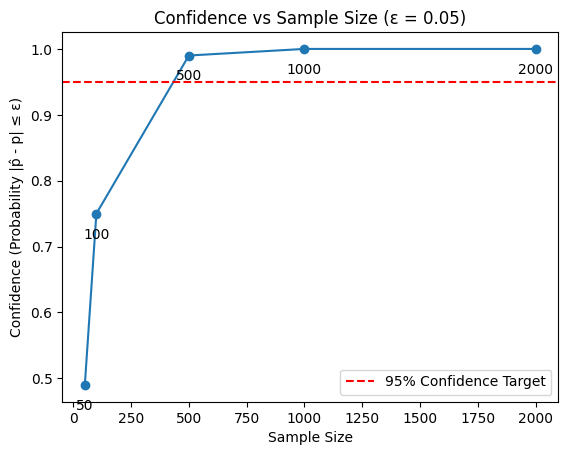

In [ ]:
ground_truth = 0.745
analysis_plot(sample_sizes, estimates_coin, ground_truth, precision)

## Domain 2: Cooking Robot
* 6 fluents with 2 values
* 1 flunet with 3 values
* 11 steps, all conditioned actions

In [ ]:
domain_string_cooking = read_domain("complex_domains", "cooking_robot.txt")
test_mdp_cooking, test_policy_cooking, test_steps_cooking, test_domain_cooking = create_model(domain_string_cooking)
test_samples_cooking = sample(test_mdp_cooking, test_policy_cooking, test_steps_cooking, sample_sizes, trials_n)

current sample size: 50
current sample size: 100
current sample size: 500
current sample size: 1000
current sample size: 2000


In [ ]:
query_time = 11
query_literal = "soup=plated"
estimates_cooking = []
for sample_size in test_samples_cooking:
    sub_estimates = []
    for batch in sample_size:
        estimates = estimate(test_domain_cooking, query_time, query_literal, batch)
        sub_estimates.append(estimates)
    estimates_cooking.append(sub_estimates)

50 0.52
100 0.75
500 0.96
1000 1.0
2000 1.0


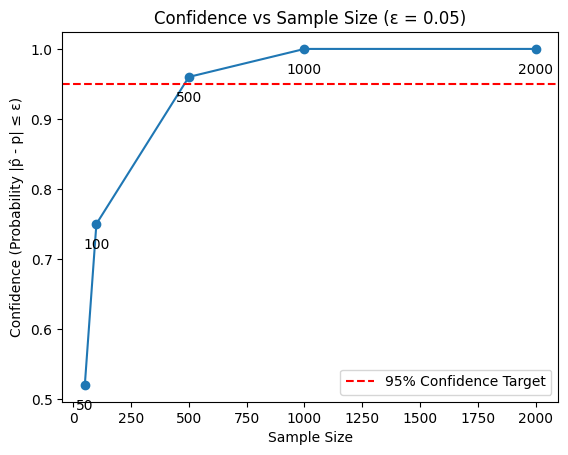

In [ ]:
ground_truth = 0.95**6 * (1-0.5**4) * (1- 0.05)
analysis_plot(sample_sizes, estimates_cooking, ground_truth, precision)